### Transfer Learning with Pytorch

### 1.What is Transfer Learning 

- Transfer Learning is speciafically using a neural network that has been pre-trained on a much larger dataset.
- The main benefit of using transfer learning is that the neural network  has already learn the important features from large dataset.
- When we use that netwrork on our own dataset, we just need to tweak a few things to achieve good results.

![](https://miro.medium.com/max/1400/1*Ww3AMxZeoiB84GVSRBr4Bw.png)

### 2.When to use Transfer Learning?
- It used when dataset is very small.
- Due to huge computational Power.

![](https://miro.medium.com/max/1400/1*9GTEzcO8KxxrfutmtsPs3Q.png)

### Dataset used in pretrained Model

![](https://debuggercafe.com/wp-content/uploads/2019/12/imagenet.png)

* Images : 14 Millions
* classes : 22000
* Organize : [ILSVRC](https://image-net.org/challenges/LSVRC/2017/index)

### 1.Load Libraries

In [1]:
# torch loaded..!!!
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

# torchvision loaded..!!!
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary

# other libraries loaded,,,!!!
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


### 2.Check the GPU availability

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### 3. Download the dataset and prepare

In [3]:
# Tranforms for the training, validation, and testing sets
transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [4]:
# Download the training data and testing data
trainset = torchvision.datasets.CIFAR10(root='./data_new', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data_new', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Load the data using DataLoader
trainLoader = torch.utils.data.DataLoader(trainset, batch_size= 32, shuffle=True, num_workers=2)
testLoader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

### 4.Downloading the ResNet18 Network
![](https://i.imgur.com/XwcnU5x.png)

In [6]:
for batch_1 in trainLoader:
    batch = batch_1
    break

print(f"Image shape:{batch[0].shape}") # Image pixels -> (batch, channel, height, width)
print(f"Label shape:{batch[1].shape}") # Label -> (batch, 1)

Image shape:torch.Size([32, 3, 224, 224])
Label shape:torch.Size([32])


### 5.Freezing Convolution Weights
- Original dataset contains 1000 Classes.
- Last layer set `resnet18.fc = Linear(512,10)`.
- Freeze all the weights of convolution block.

In [18]:
# Freeze parameters so we don't backprop through them
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.features.parameters():
    param.requires_grad = False 
    1
vgg16.classifier[6].out_features = 10
vgg16 = vgg16.to(device)
print(vgg16)
print(str(summary(vgg16, (3, 224, 224))))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 6.Optimizer and Loss Function

In [24]:
# optimizer
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()

### Training and Validation

In [28]:
# validation function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    
    return val_loss, val_accuracy

 In validation method we are calculating the loss and accuracy. but we are not doing any backpropagating the gradient, backpropagation is only required during training

In [29]:
# training function
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

* `fit()` method calculating gradient and backpropagation.
* `fit(), validation()` will keep returning the loss and accuracy values for each epoch.

In [31]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(10):
    train_epoch_loss, train_epoch_accuracy = fit(vgg16, trainLoader)
    val_epoch_loss, val_epoch_accuracy = validate(vgg16, testLoader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')

Train Loss: 0.0138, Train Acc: 84.66
Train Loss: 0.0110, Train Acc: 87.69
Train Loss: 0.0087, Train Acc: 90.29
Train Loss: 0.0070, Train Acc: 92.06
Train Loss: 0.0053, Train Acc: 94.20
Train Loss: 0.0040, Train Acc: 95.71
Train Loss: 0.0029, Train Acc: 96.94
Train Loss: 0.0022, Train Acc: 97.78
Train Loss: 0.0016, Train Acc: 98.35
Train Loss: 0.0013, Train Acc: 98.78
100.89961864948273 minutes


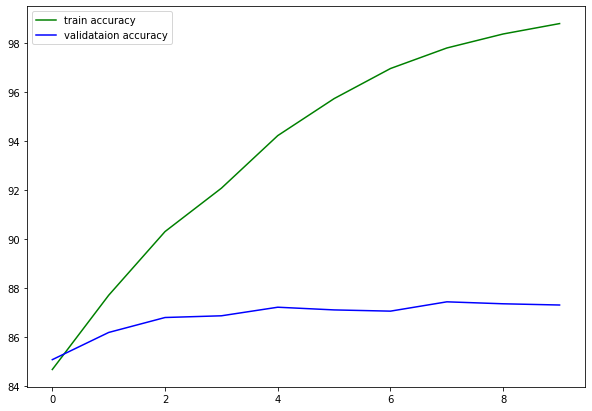

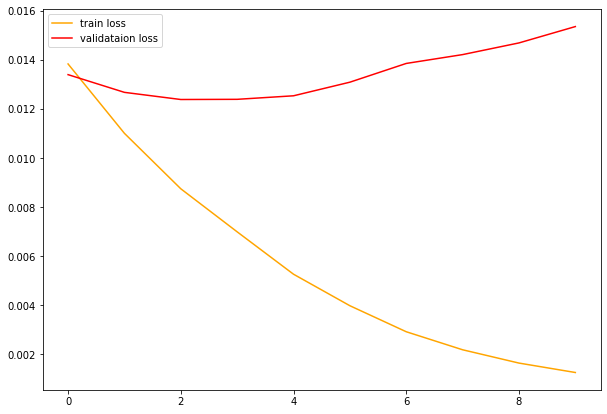

In [33]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()